# Varational AutoEncoder Benchmarks 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
import CustomGenerator
# from CustomGenerator import ReturnsDataGen, CodeBookDataGen

In [2]:
import importlib
importlib.reload(CustomGenerator)
from CustomGenerator import ReturnsDataGen, CodeBookDataGen

In [3]:
# Load data
data = np.load('master_data/data.npy')
train_batches = data.shape[0] # N hereafter. Number of training images in database.
length = data.shape[1] 
stocks = data.shape[2]
data_gen = ReturnsDataGen(data)
data.shape

Number of training batches:  189
Length of each batch:  250
Number of stocks:  363


(189, 250, 363)

## VAE - Dense layers

In [4]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def encoder_dense(laten_dim=10, input_dim=250):
    inputs = keras.Input(shape=(input_dim,), name='encoder_input')
    x = layers.Dense(80, activation="relu", name='dense_1')(inputs)
    x = layers.Dense(40, activation="relu", name='dense_2')(x)
    x = layers.Dense(20, activation="relu", name='dense_3')(x)
    z_mean = layers.Dense(laten_dim, activation="relu", name='z_mean')(x)
    z_log_var = layers.Dense(laten_dim, activation="relu", name='z_std')(x)
    print(z_mean.shape)
    print(z_log_var.shape)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name="encoder") 

def decoder_dense(laten_dim=10, input_dim=250):
    latent_inputs = keras.Input(shape=(laten_dim,), name='decoder_input')
    x = layers.Dense(20, activation="relu", name='dense_5')(latent_inputs)
    x = layers.Dense(40, activation="relu", name='dense_6')(x)
    x = layers.Dense(80, activation="relu", name='dense_7')(x)
    outputs = layers.Dense(input_dim, activation="relu", name='dense_8')(x)
    return keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder") 

def encoder_conv(laten_dim=100, input_dim=250):
    inputs = keras.Input(shape=(input_dim, 1), name='encoder_input')
    x = layers.Conv1D(1, 3, activation="relu", strides=2, padding="valid")(inputs)
    x = layers.Conv1D(12, 3, activation="relu", strides=2, padding="valid")(x)
    x = layers.Conv1D(24, 3, activation="relu", strides=2, padding="valid")(x)
    x = layers.Conv1D(48, 3, activation="relu", strides=2, padding="valid")(x)
    x = layers.Conv1D(96, 3, activation="relu", strides=2, padding="valid")(x)
    # x = layers.Conv1D(1, 3, activation="relu", strides=2, padding="valid")(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(laten_dim, activation="relu", name='z_mean')(x)
    z_log_var = layers.Dense(laten_dim, activation="relu", name='z_std')(x)
    print(z_mean.shape)
    print(z_log_var.shape)
    z = Sampling()([z_mean, z_log_var])
    return keras.Model(inputs=inputs, outputs=[z_mean, z_log_var, z], name="encoder") 

def decoder_conv(laten_dim=100, input_dim=250):
    latent_inputs = keras.Input(shape=(laten_dim,), name='decoder_input')
    x = layers.Dense(6*96, activation="relu", name='dense_5')(latent_inputs) 
    x = layers.Reshape((6, 96))(x)
    # x = layers.Conv1DTranspose(96, 3, activation="relu", strides=2, padding="valid")(x)
    x = layers.Conv1DTranspose(48, 3, activation="relu", strides=2, padding="valid", output_padding =1)(x)
    x = layers.Conv1DTranspose(24, 3, activation="relu", strides=2, padding="valid", output_padding =1)(x)
    x = layers.Conv1DTranspose(12, 3, activation="relu", strides=2, padding="valid", output_padding =1)(x)
    x = layers.Conv1DTranspose(1, 3, activation="relu", strides=2, padding="same")(x)
    outputs = layers.Conv1DTranspose(1, 3, activation="relu", strides=2, padding="valid", output_padding =1)(x)
    return keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

In [5]:
encoder_fc = encoder_conv()
encoder_fc.summary()

2023-08-01 15:55:16.762029: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-01 15:55:16.762071: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-01 15:55:16.762084: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-01 15:55:16.762133: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-01 15:55:16.762153: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(None, 100)
(None, 100)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 250, 1)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 124, 1)               4         ['encoder_input[0][0]']       
                                                                                                  
 conv1d_1 (Conv1D)           (None, 61, 12)               48        ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 30, 24)               888       ['conv1d_1[0][0]']            
                                                                    

In [6]:
decoder_fc = decoder_conv()
decoder_fc.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense_5 (Dense)             (None, 576)               58176     
                                                                 
 reshape (Reshape)           (None, 6, 96)             0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 14, 48)            13872     
 anspose)                                                        
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 30, 24)            3480      
 Transpose)                                                      
                                                                 
 conv1d_transpose_2 (Conv1D  (None, 62, 12)            876 

In [7]:
encoder = encoder_dense()
decoder = decoder_dense()

print(encoder.summary())


(None, 10)
(None, 10)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 250)]                0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 80)                   20080     ['encoder_input[0][0]']       
                                                                                                  
 dense_2 (Dense)             (None, 40)                   3240      ['dense_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 20)                   820       ['dense_2[0][0]']             
                                                                      

In [8]:

print(decoder.summary())

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 dense_5 (Dense)             (None, 20)                220       
                                                                 
 dense_6 (Dense)             (None, 40)                840       
                                                                 
 dense_7 (Dense)             (None, 80)                3280      
                                                                 
 dense_8 (Dense)             (None, 250)               20250     
                                                                 
Total params: 24590 (96.05 KB)
Trainable params: 24590 (96.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # print(reconstruction.shape)
            # print(data.shape)
            reconstruction_loss = tf.metrics.mean_squared_error(data, reconstruction)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            #     )
            # )



            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## VAE - Dense layers

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.legacy.Adam())
vae.fit(data_gen, epochs=30, )

Epoch 1/30


2023-08-01 15:55:24.561882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


189/189 [==============================] - 3s 11ms/step - loss: 0.0877 - reconstruction_loss: 0.0089 - kl_loss: 0.1030
New batch index:  179
Epoch 2/30
189/189 [==============================] - 2s 11ms/step - loss: 0.1684 - reconstruction_loss: 0.0045 - kl_loss: 0.1772
New batch index:  92
Epoch 3/30
189/189 [==============================] - 2s 11ms/step - loss: 0.2319 - reconstruction_loss: 0.0048 - kl_loss: 0.2400
New batch index:  14
Epoch 4/30
189/189 [==============================] - 2s 12ms/step - loss: 0.6380 - reconstruction_loss: 0.0058 - kl_loss: 0.8198
New batch index:  106
Epoch 5/30
189/189 [==============================] - 2s 11ms/step - loss: 0.9323 - reconstruction_loss: 0.0053 - kl_loss: 0.9292
New batch index:  71
Epoch 6/30
189/189 [==============================] - 2s 11ms/step - loss: 1.3672 - reconstruction_loss: 0.0075 - kl_loss: 1.6095
New batch index:  188
Epoch 7/30
189/189 [==============================] - 2s 11ms/step - loss: 1.7508 - reconstruction_los

In [12]:
loss = vae.history.history['loss']
reconstruction_loss= vae.history.history['reconstruction_loss']
kl_loss = vae.history.history['kl_loss']


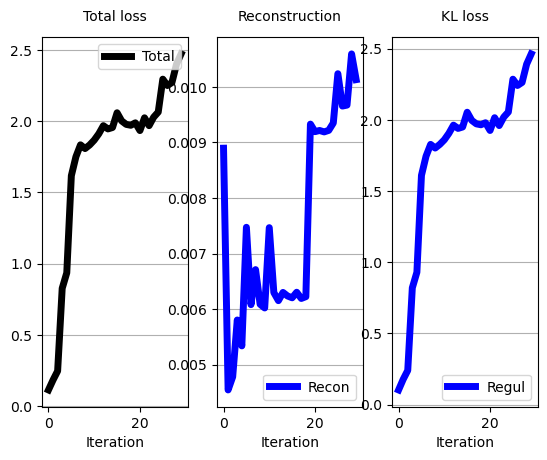

In [13]:
fig, axes = plt.subplots(1, 3, sharex=False, sharey=False)

x_points = np.arange(0, len(loss), 1)
axes[0].set_title("Total loss", fontsize=10, y=1.022)
axes[0].plot(x_points, loss, color="black", label="Total", linewidth=5)
axes[0].yaxis.grid(True, zorder=0)
axes[0].set_xlabel('Iteration', fontsize=10)
axes[0].legend(loc='upper right')

axes[1].set_title("Reconstruction", fontsize=10, y=1.022)
axes[1].plot(x_points, reconstruction_loss, color="blue", label="Recon", linewidth=5)
axes[1].yaxis.grid(True, zorder=0)
axes[1].set_xlabel('Iteration', fontsize=10)
axes[1].legend(loc='lower right')

axes[2].set_title("KL loss", fontsize=10, y=1.022)
axes[2].plot(x_points, kl_loss, color="blue", label="Regul", linewidth=5)
axes[2].yaxis.grid(True, zorder=0)
axes[2].set_xlabel('Iteration', fontsize=10)
axes[2].legend(loc='lower right')

plt.show()      

### Reconstruction 

In [14]:
def plot_rec_series(x_hat_series, x_series):
    fig, axes = plt.subplots(3,1, figsize=(30,20), dpi= 50)
    axes[0].plot(x_series, label='original')
    axes[0].plot(x_hat_series, label='reconstructed')
    axes[0].legend()
    axes[1].plot(x_hat_series, label='reconstructed', color='darkorange')
    axes[1].legend()
    axes[2].plot(x_series, label='original')
    axes[2].legend()
    plt.show()

In [18]:
series_idx = 0 
batch_idx = 0
batch= data[batch_idx]
print(batch.shape)
batch= np.transpose(batch)
print(batch.shape)
# batch= np.expand_dims(batch, axis=2)
print(batch.shape)

x_hat = vae.predict(batch)
print(x_hat.shape)

x_hat_series = x_hat[series_idx,:]
x_series = batch[series_idx,:]

plot_rec_series(x_hat_series, x_series)

(250, 363)
(363, 250)
(363, 250)


NotImplementedError: in user code:

    File "/Users/danielrzapatas/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/Users/danielrzapatas/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/danielrzapatas/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/danielrzapatas/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/Users/danielrzapatas/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/danielrzapatas/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py", line 596, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer 'vae' (type VAE).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer 'vae' (type VAE):
      • inputs=tf.Tensor(shape=(None, 250), dtype=float32)
      • training=False
      • mask=None
